<a href="https://colab.research.google.com/github/swagata87/IITKanpurPhy654/blob/main/ode_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

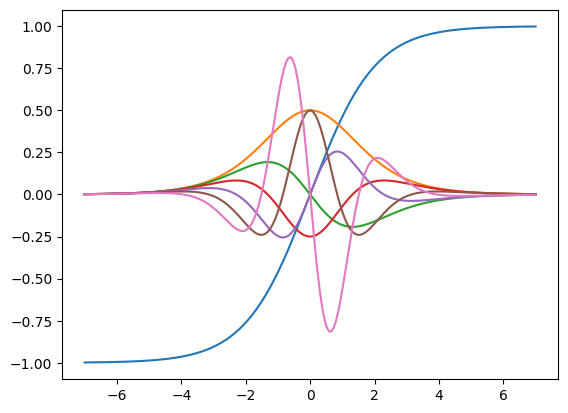

In [2]:
# AUTOGRAD EXAMPLE
# Automatic differentiation can greatly speed up prototyping and implementation of machine learning models.
def f(x): # Define a function
  y = np.exp(-x)
  return (1.0 - y ) / ( 1.0 + y )

D_f = grad( f ) # 1st derivative function
D2_f = grad( D_f ) # 2nd derivative function
D3_f = grad( D2_f ) # 3rd derivative function
D4_f = grad( D3_f ) # etc.
D5_f = grad( D4_f )
D6_f = grad( D5_f )

x = np.linspace( -7 , 7 , 200)

plt.plot(x, list(map(f,x)),
         x , list(map(D_f,x)),
         x , list(map(D2_f,x)),
         x , list(map(D3_f,x)),
         x , list(map(D4_f,x)) ,
         x , list(map(D5_f,x)) ,
         x , list(map(D6_f,x))
         )
plt.show()

In [3]:
# EXAMPLE OF
# elementwise_grad
# generally used for functions that vectorize over inputs

def tanh(x): # Define a function
   return (1.0 - np.exp((-2 * x))) / (1.0 + np.exp(-(2 * x)))

In [4]:
grad_tanh = grad(tanh)  # Obtain its gradient function
grad_tanh(1.0) # Evaluate the gradient at x = 1.0

0.419974341614026

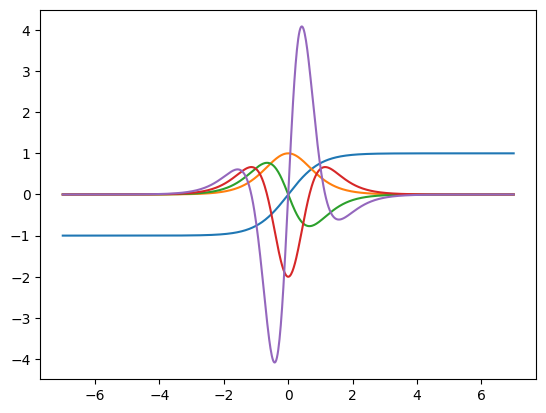

In [6]:
x = np.linspace(-7, 7, 700)
plt.plot(x, tanh(x),
         x, elementwise_grad(tanh)(x), # first  derivative
         x, elementwise_grad(elementwise_grad(tanh))(x), # second derivative
         x, elementwise_grad(elementwise_grad(elementwise_grad(tanh)))(x), # third  derivative
         x, elementwise_grad(elementwise_grad(elementwise_grad(elementwise_grad(tanh))))(x), # fourth derivative
         )
plt.show()
# END OF EXAMPLE

# Solving ODEs with Deep Learning

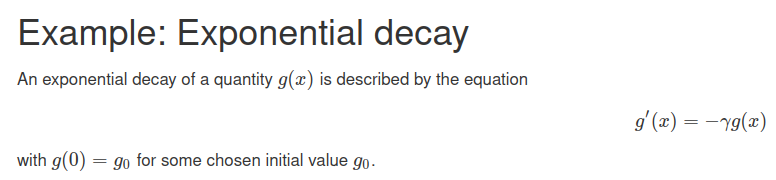

The analytical solution is

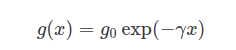

We will use a neural network to solve the ODE.


To begin with, a trial solution must be chosen. A general trial solution for ordinary differential equations could be

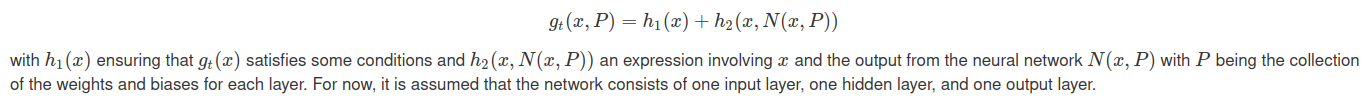

A possible way to ensure that gt(0,P)=g0 is the following

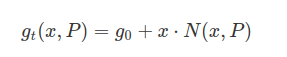

In [7]:
# sigmoid function will be used as activation function for hidden layer in NN
def sigmoid(z):
    return 1/(1 + np.exp(-z))

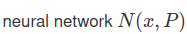

In [8]:
# input layer, one hidden layer, and output layer
def neural_network(params, x):

    # Find the weights and biases for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    w_hidden = params[0]
    w_output = params[1]

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # input layer
    x_input = x

    ## Hidden layer:

    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)

    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    ## Output layer:

    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(w_output, x_hidden)
    x_output = z_output

    return x_output

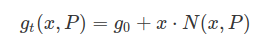

In [9]:
# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)


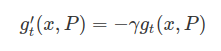

In [10]:
# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

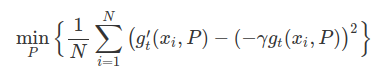

In [11]:
# The cost function:
def cost_function(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    #d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)


In [16]:
# Solve the exponential decay ODE using neural network with one hidden layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, alpha):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, x))

    return P

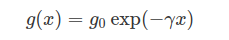

In [17]:
def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

Initial cost: 400.446
Final cost: 0.904609
Max absolute difference: 0.414191


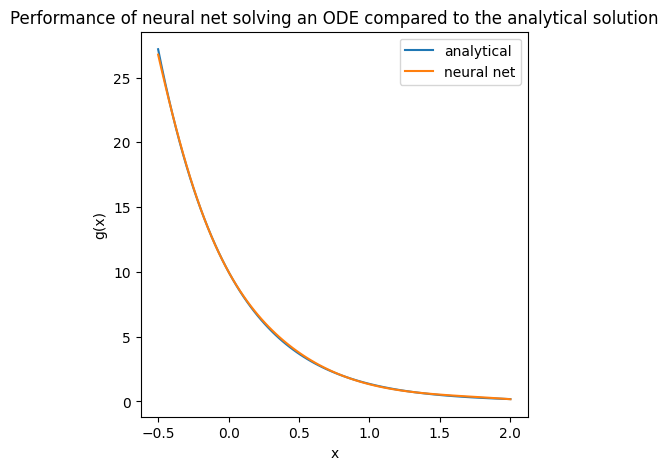

In [19]:
# Solve the given problem
if __name__ == '__main__':
    # Set seed such that the weight are initialized
    # with same value for every run. This way we can reproduce
    # exactly same result every time we run this code.
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 100
    x = np.linspace(-0.5, 2, N)

    ## Set up the initial parameters
    num_hidden_neurons = 10
    num_iter = 6000
    alpha = 0.001 # learning rate

    # Use the network
    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, alpha)

    # Print the deviation from the trial solution and true solution
    res = g_trial(x,P)
    res_analytical = g_analytic(x)

    print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

    # Plot the results
    plt.figure(figsize=(5,5))

    plt.title('Performance of neural net solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','neural net'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()
